## Using Colab 
#### Upload    [notebook2script.py](https://github.com/fastai/course-v3/blob/master/nbs/dl2/notebook2script.py) 

#### Rules 

---
- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Lesson 8 deep learning from Foundation

[Lesson 8 video](https://course.fast.ai/videos/?lesson=8)

In [0]:
#export
import os

os.system("pip install fire")
os.system("pip install fastai")

0

#### Test export notebook

In [0]:
#Export
TEST = 'test'

#### Save and Download the notebook and upload in current folder

In [0]:
! python notebook2script.py 00_export.ipynb

Converted 00_export.ipynb to exp/nb_00.py


### How it works

In [0]:
import json

d = json.load(open('00_export.ipynb', 'r'))['cells']
d[6]

{'cell_type': 'code',
 'execution_count': None,
 'metadata': {},
 'outputs': [],
 'source': []}

### Matrix Multiplication from foundations

#### check imports

In [0]:
#export
% load_ext autoreload
% autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from exp.nb_00 import *
import operator

In [0]:
#export

import operator
def test(a, b, cmp, cname=None):
    if cname is None:
        cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

def test_eq(a, b):
    test(a, b, operator.eq, "==")

In [0]:
test_eq(TEST, "test")

### Get Data

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
from torch import tensor
from torch import nn
import matplotlib.pyplot as plt

In [0]:
#export
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

In [0]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [0]:
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n == y_train.shape[0] == 50000
test_eq(c, 28*28)     # 784 
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [0]:
mpl.rcParams["image.cmap"] = 'gray'

Text(0.5, 0, 'tensor(5)')

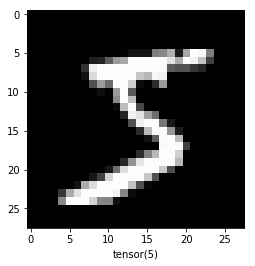

In [0]:
img = x_train[0]

plt.imshow(img.view((28, 28)));
plt.xlabel((str(y_train[0])))

In [0]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

##### Matrix Multiplication

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [0]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
% time t1 = matmul(m1, m2)

CPU times: user 698 ms, sys: 0 ns, total: 698 ms
Wall time: 698 ms


#### This is kinda slow - what if we could speed it up by 50,000 times?

#### Elementwisw ops
    Operators (+,-,\*,/,>,<,==) are usually element-wise.
    Examples of element-wise operations:

In [0]:
a = tensor([10., 6., -4.])
b = tensor([2., 8., 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [0]:
a + b

tensor([12., 14.,  3.])

In [0]:
(a < b).float().mean()

tensor(0.6667)

In [0]:
m = tensor([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

#### Using Frobeniums Norm we can speed it up

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [0]:
(m*m).sum().sqrt()    # |multiply| norm -> sum -> root

tensor(16.8819)

#### Elementwise matmul

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [0]:
% time t2 = matmul(m1, m2)

CPU times: user 1.5 ms, sys: 168 µs, total: 1.67 ms
Wall time: 1.42 ms


In [0]:
assert t1.shape == t2.shape

##### Test_near

In [0]:
#export
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b):
    test(a, b, near)

In [0]:
test_near(t1, t2)

### Brodcasting 
The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html)

In [0]:
a

tensor([10.,  6., -4.])

In [0]:
a > 0          # 0 => [0, 0, 0]

tensor([1, 1, 0], dtype=torch.uint8)

In [0]:
 a + 1         # a => [10.,  6., -4.] + 
               # 1 => [1, 1, 1]

tensor([11.,  7., -3.])

#### Broadcasting a vector to a matrix

In [0]:
c = tensor([10., 20., 30])
c

tensor([10., 20., 30.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [0]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [0]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [0]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [0]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [0]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [0]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [0]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
m * c.unsqueeze(0), m * c.unsqueeze(1)

(tensor([[ 10.,  40.,  90.],
         [ 40., 100., 180.],
         [ 70., 160., 270.]]), tensor([[ 10.,  20.,  30.],
         [ 80., 100., 120.],
         [210., 240., 270.]]))

In [0]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape, c.unsqueeze(-1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]), torch.Size([3, 1]))

In [0]:
c.shape, c[None].shape, c[:, None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

##### Matmul with broadcasting

- a[i, :] looks at a rank 1 tensor
- .unsqueeze(-1) makes it 2d, the -1 means last dimension
- x b broadcast over b
- .sum(dim=0) sum along the first axis

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(0)
    return c

In [0]:
% time t3 = matmul(m1, m2)

CPU times: user 771 µs, sys: 0 ns, total: 771 µs
Wall time: 559 µs


#### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

In [0]:
## c[i, j] += a[i, k] * b[k, j]
##  [i, k] * [k, j] -> [i, j]
##  ik,kj -> ij

def matmul(a, b):
    return torch.einsum("ik,kj->ij", a, b)

In [0]:
% timeit -n 10 t4 = matmul(m1, m2)

10 loops, best of 3: 48.5 µs per loop


In [0]:
% time t4 = matmul(m1, m2)

CPU times: user 121 µs, sys: 42 µs, total: 163 µs
Wall time: 170 µs


In [0]:
test_near(t1, t2)
test_near(t1, t3)
test_near(t1, t4)

### pytorch opUnfo

We've speed things up, but the pytorch op is optimized even more. Even with vectorized operations, thers's slow and fast ways of handling memory. Unfortunately most programmers don't have access to this, short of using functions provided in BLAS libraries (Basic Linear Algebra Subprograms)

##### Using pytorch matmul function

In [0]:
% time t5 = torch.matmul(m1, m2)

CPU times: user 64 µs, sys: 22 µs, total: 86 µs
Wall time: 92 µs


### To convert this notebook download and upload in current dir then run the below cell

In [0]:
# ! python notebook2script.py 01_matmul.ipynb

## Making Relu / Initialization

In [0]:
% reload_ext autoreload
% autoreload 2
% matplotlib inline

In [0]:
# from exp.nb_01 import *

In [0]:
#export
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'r') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, m, s):
    return (x - m) / s

In [0]:
def normalize(x, m, s):
    return (x - m) / s

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()

train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [0]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()

train_mean, train_std

(tensor(3.0614e-05), tensor(1.))

In [0]:
#export
def test_near_zero(a, tol=1e-3):
    assert a.abs() < tol, f"Near zero: {a}"

In [0]:
test_near_zero(train_mean)
test_near_zero(1 - train_std)

In [0]:
n, m = x_train.shape       ## size of training set
c = y_train.max() + 1      ## No. of activation in our model
n, m, c

(50000, 784, tensor(10))

## Foundation Version

### Basic Architecture
#### First model
our first model will have 50 hidden units. it will also have 2 hidden layers

1. first layer (w1): will be size of input)shape x hidden units
2. second layer (w2): will be size of hidden units

In [0]:
##   No. of hidden units
nh = 50

In [0]:
## simplified kaiming init / he init
w1 = torch.randn(m, nh) / math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1) / math.sqrt(nh)
b2 = torch.zeros(1)

In [0]:
test_near_zero(w1.mean())
test_near_zero(w1.std() - 1/math.sqrt(m))

### Getting normalized weights

Initializing weights matters. Large network was trained with very specific weights initialization in this [paper](https://arxiv.org/abs/1901.09321). It turns out even in one-cycle training, those first iterations are very important 

In [0]:
x_valid.mean(), x_valid.std()

(tensor(-0.0058), tensor(0.9924))

In [0]:
def lin(x, w, b):
    return x @ w + b

In [0]:
t = lin(x_valid, w1, b1)

In [0]:
t.mean(), t.std()

(tensor(-0.0418), tensor(0.9636))

In [0]:
def relu(x):
    return x.clamp_min(0.)

### Check for mean 0 and std 1

In [0]:
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.3612), tensor(0.5400))

### How to deal with Relu --> (0, 1)

Imagenet winners paper
- Competition winners [papers](https://arxiv.org/abs/1502.01852) have many good ideas. This introduces ReLu, resnet, kaiming normalization

From pytorch docs: `a: the negative slope of the rectifier used after this layer (0 for ReLU by default)`

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)

In [0]:
### kaiming init / he init for relu
w1 = torch.randn(m, nh) * math.sqrt(2/m)

In [0]:
w1.mean(), w1.std()

(tensor(-9.3452e-05), tensor(0.0507))

In [0]:
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.6052), tensor(0.8521))

#### and now the result is much closer to mean 0, std 1

In [0]:
def relu(x):
    return x.clamp_min(0.) - 0.5

In [0]:
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.1052), tensor(0.8521))

In [0]:
for i in range(10):
    w1 = torch.randn(m, nh) * math.sqrt(2/m)
    t1= relu(lin(x_valid, w1, b1))
    print(i, t1.mean(), t1.std(), "||")

0 tensor(-0.0399) tensor(0.7650) ||
1 tensor(0.0703) tensor(0.8274) ||
2 tensor(0.0269) tensor(0.8155) ||
3 tensor(0.0719) tensor(0.8274) ||
4 tensor(0.1054) tensor(0.8796) ||
5 tensor(0.0108) tensor(0.8262) ||
6 tensor(0.0766) tensor(0.8356) ||
7 tensor(0.0389) tensor(0.7672) ||
8 tensor(0.1517) tensor(0.9129) ||
9 tensor(0.0720) tensor(0.8543) ||


Forward pass is a matrix multiply and backward pass is a matrix multiply with a transpose. And they finally recommend sqrt(2 over activations). Now that we understand how to normalize weights and how to calculate the kaiming normal, lets use the pytorch version of it



In [0]:
#Export 
from torch.nn import init

In [0]:
w1 = torch.empty(m, nh)
init.kaiming_normal_(w1, mode="fan_out")
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.0975), tensor(0.8449))

### Fan in or Fan out
mode: either 'fan_in' (default) or 'fan_out'. Choosing `fan_in`
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing `fan_out` preserves the magnitudes in the
        backwards pass.

In [0]:
init.kaiming_normal_??

In [0]:
w1.shape

torch.Size([784, 50])

In [0]:
import torch.nn

In [0]:
torch.nn.Linear(m, nh).weight.shape

torch.Size([50, 784])

In [0]:
torch.nn.functional.linear??

In [0]:
torch.nn.Conv2d??

In [0]:
torch.nn.modules.conv._ConvNd??

In [0]:
## kaiming init / he init for relu
w1 = torch.randn(m, nh) * math.sqrt(2/m)
t1 = relu(lin(x_valid, w1, b1))
t1.mean(), t1.std()

(tensor(0.1179), tensor(0.8728))

In [0]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [0]:
% timeit -n 10 _ = model(x_valid)

10 loops, best of 3: 6.18 ms per loop


In [0]:
assert model(x_valid).shape == torch.Size([x_valid.shape[0], 1])

### Loss Function: MSE

In [0]:
model(x_valid).shape

torch.Size([10000, 1])

In [0]:
def mse(output, targ):
    return (output.squeeze(-1) - targ).pow(2).mean()

In [0]:
y_train, y_valid = y_train.float(), y_valid.float()

In [0]:
pred = model(x_train)

In [0]:
pred.shape

torch.Size([50000, 1])

In [0]:
mse(pred, y_train)

tensor(29.9473)

### Gradients and backward pass

In [0]:
def mse_grad(inp, targ): 
    # grad of loss with respect to output of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [0]:
def relu_grad(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [0]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [0]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # we don't actually need the loss in backward!
    # loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [0]:
w1.shape

torch.Size([784, 50])

In [0]:
forward_and_backward(x_train, y_train)

In [0]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = x_train.g.clone()

In [0]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [0]:
def forward(inp, targ):
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    l3 = l2 @ w22 + b22
    return mse(l3, targ)

In [0]:
loss = forward(xt2, y_train)

In [0]:
loss.backward()

In [0]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig )

In [0]:
## Test
#w1

## Refactor Model

#### Layers as classes

In [0]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [0]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        # Creating a giant outer product, just to sum it, is inefficient!
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [0]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [0]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [0]:
% time loss = model(x_train, y_train)

CPU times: user 84.4 ms, sys: 555 µs, total: 85 ms
Wall time: 43.2 ms


In [0]:
% time model.backward()

CPU times: user 3.21 s, sys: 4.48 s, total: 7.69 s
Wall time: 3.96 s


In [0]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

 ### Module.forward()

In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self):
        raise Exception("Not Implemented")
    
    def backward(self):
        self.bwd(self.out, *self.args)

In [0]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min(0.) - 0.5

    def bwd(self, out, inp):
        inp.g = (inp > 0).float() * out.g

In [0]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w, b

    def forward(self, inp):
        return inp @ self.w + self.b

    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [0]:
class Mse(Module):
    def forward(self, inp, targ):
        return (inp.squeeze() - targ).pow(2).mean()
    
    def bwd(self, out, inp, targ):
        inp.g = 2 * (inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [0]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()

    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)

    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [0]:
#% time loss = model(x_train, y_train)

In [0]:
#% time model.backward()

### Lin() without einsum

In [0]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w, b

    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [0]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model()

In [0]:
% time  loss = model(x_train, y_train)

CPU times: user 99.4 ms, sys: 0 ns, total: 99.4 ms
Wall time: 50.1 ms


In [0]:
% time model.backward()

CPU times: user 286 ms, sys: 42.7 ms, total: 329 ms
Wall time: 184 ms


In [0]:
test_near(w2g, w2.g)
#test_near(b2g, b2.g)
test_near(w1g, w1.g)
#test_near(b1g, b1.g)
test_near(ig, x_train.g)

### nn.Linear and nn.Module

In [0]:
#export
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse

    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x.squeeze(), targ)


In [0]:
model = Model(m, nh, 1)

In [0]:
% time loss = model(x_train, y_train)

CPU times: user 77.7 ms, sys: 0 ns, total: 77.7 ms
Wall time: 46.9 ms


In [0]:
% time loss.backward()

CPU times: user 104 ms, sys: 322 µs, total: 104 ms
Wall time: 52.8 ms


### Export save -> download -> upload

In [0]:
! python notebook2script.py fastai_lesson_8.ipynb

Converted fastai_lesson_8.ipynb to exp/nb_fastai.py


# End of lesson 8